### Dataset

#### Sample dataset

In [ ]:
import random

input_file = "emojitweets.txt"
output_file = "sampled_tweets.txt"

sampled_emojitweets = 0.001  

with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8-sig") as outfile:
    for line in infile:
        if random.random() < sampled_emojitweets:
            outfile.write(line)

In [ ]:
import csv

input_file = "sampled_tweets.txt"
output_file = "emojitweets.csv"

with open(input_file, "r", encoding="utf-8-sig") as infile, open(output_file, "w", newline="", encoding="utf-8-sig") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(["tweet"])  
    
    for line in infile:
        line = line.strip()
        if line:  
            writer.writerow([line])


### Preprocessing

#### Create emoji and text columns

In [1]:
import pandas as pd
import emoji

df = pd.read_csv("emojitweets.csv")

def extract_emojis(s):
    return ''.join(c for c in s if emoji.is_emoji(c))

def remove_emojis(s):
    return ''.join(c for c in s if not emoji.is_emoji(c))

df['emoji'] = df['tweet'].apply(lambda x: extract_emojis(str(x)))

df['text'] = df['tweet'].apply(lambda x: remove_emojis(str(x)))

df.to_csv("emojitweets.csv", index=False, encoding="utf-8-sig")

In [2]:
df.head()

,tweet,emoji,text,compound,sentiment
0,"I'll give you my number, when you text me, I b...",😂,"I'll give you my number, when you text me, I b...",-0.3818,negative
1,🤣🤣🤣 I approve.,🤣🤣🤣,I approve.,0.0000,neutral
2,Herb’s been a daddy for less than a week &amp;...,🏆😂😂😂😂😂😂😂😂,Herb’s been a daddy for less than a week &amp;...,0.0000,neutral
3,Fake news about the demands is now cleared don...,🕺💃,Fake news about the demands is now cleared don...,-0.3085,negative
4,Keep trying 😂,😂,Keep trying,0.0000,neutral


#### Data Exploration

In [3]:
print(df.isna().any())

tweet        False
emoji        False
text         False
compound     False
sentiment    False
dtype: bool


In [4]:
print(df.shape)    
print(df.info())


(18989, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18989 entries, 0 to 18988
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet      18989 non-null  object 
 1   emoji      18989 non-null  object 
 2   text       18989 non-null  object 
 3   compound   18989 non-null  float64
 4   sentiment  18989 non-null  object 
dtypes: float64(1), object(4)
memory usage: 741.9+ KB
None


### Sentiment Analysis of Text Column

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df = pd.read_csv("emojitweets.csv")

sia = SentimentIntensityAnalyzer()

df['compound'] = df['text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

def sentiment_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['compound'].apply(sentiment_label)

In [6]:
df.to_csv("emojitweets.csv", index=False, encoding="utf-8-sig")

In [7]:
df.head()

,tweet,emoji,text,compound,sentiment
0,"I'll give you my number, when you text me, I b...",😂,"I'll give you my number, when you text me, I b...",-0.3818,negative
1,🤣🤣🤣 I approve.,🤣🤣🤣,I approve.,0.0000,neutral
2,Herb’s been a daddy for less than a week &amp;...,🏆😂😂😂😂😂😂😂😂,Herb’s been a daddy for less than a week &amp;...,0.0000,neutral
3,Fake news about the demands is now cleared don...,🕺💃,Fake news about the demands is now cleared don...,-0.3085,negative
4,Keep trying 😂,😂,Keep trying,0.0000,neutral


In [8]:
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    8727
neutral     7274
negative    2988
Name: count, dtype: int64


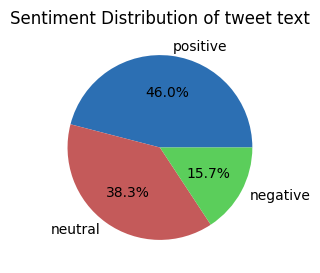

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=["#2c6fb3","#c45a5a","#5bce5b"])
plt.title('Sentiment Distribution of tweet text')
plt.show()


### Assigning Sentiment to Emojis

In [10]:
from collections import defaultdict

emoji_sentiments = defaultdict(lambda: {'positive': 0, 'neutral': 0, 'negative': 0})

for idx, row in df.iterrows():
    if pd.isna(row['emoji']):
        continue  
    emojis_in_row = set(row['emoji'])  
    sentiment = row['sentiment']
    for e in emojis_in_row:
        emoji_sentiments[e][sentiment] += 1

rows = []
for e, counts in emoji_sentiments.items():
    total = sum(counts.values())
    percentages = {s: round((c/total)*100, 1) for s, c in counts.items()}
    rows.append({
        'emoji': e,
        'count': total, 
        'positive_%': percentages['positive'],
        'neutral_%': percentages['neutral'],
        'negative_%': percentages['negative']
    })

emoji_df = pd.DataFrame(rows)

emoji_df.to_csv("emoji_sentiment_stats.csv", index=False,encoding="utf-8-sig")

print(emoji_df.head())


  emoji  count  positive_%  neutral_%  negative_%
0     😂   2491        33.2       40.3        26.5
1     🤣    274        29.9       44.5        25.5
2     🏆    123        65.9       29.3         4.9
3     🕺     28        42.9       42.9        14.3
4     💃     38        34.2       52.6        13.2


### Visualisation

#### Top 20 Emojis by Frequency (Bar Chart)

In [12]:
import plotly.express as px

N = 20
top_n = emoji_df.sort_values("count", ascending=False).head(N)

fig = px.bar(
    top_n,
    x="emoji",
    y="count",
    text="count",
    title=f"Top {N} Emojis by Frequency"
)
fig.update_traces(textposition="outside")

fig.write_html("top_20_emojis.html")

fig.show()

#### Bubble Chart (Emoji vs Count vs Sentiment)

In [13]:
fig = px.scatter(
    emoji_df,
    x="positive_%",
    y="negative_%",
    size="count",
    text="emoji",
    hover_data=["neutral_%"],
    title="Emoji Bubble Chart (Positive% vs Negative% vs Frequency)"
)
fig.update_traces(textposition="middle center")
fig.write_html("emoji_bubble_chart.html")

fig.show()

#### Pie / Donut Chart for Overall Sentiment Distribution

In [14]:
overall = {
    "Positive": emoji_df["positive_%"].mean(),
    "Neutral": emoji_df["neutral_%"].mean(),
    "Negative": emoji_df["negative_%"].mean()
}

fig = px.pie(
    names=list(overall.keys()),
    values=list(overall.values()),
    hole=0.4,
    title="Overall Sentiment Distribution"
)
fig.write_html("sentiment_distribution.html")
fig.show()

#### Emoji Word Cloud (Approximation using Scatter Plot)

In [15]:
import plotly.graph_objects as go
import numpy as np

emoji_top200 = emoji_df.sort_values(by="count", ascending=False).head(200).reset_index(drop=True)

np.random.seed(42)
x = np.random.rand(len(emoji_top200))
y = np.random.rand(len(emoji_top200))

sizes = (emoji_top200["count"] / emoji_top200["count"].max()) * 80 + 20  # between 20–100

fig = go.Figure()

for i, row in emoji_top200.iterrows():
    fig.add_trace(go.Scatter(
        x=[x[i]], 
        y=[y[i]], 
        mode="text",
        text=[row["emoji"]],
        textfont=dict(size=sizes[i]),
        hovertext=f"Emoji: {row['emoji']}<br>Count: {row['count']}<br>Positive: {row['positive_%']}%<br>Neutral: {row['neutral_%']}%<br>Negative: {row['negative_%']}%",
        hoverinfo="text"
    ))

fig.update_layout(
    title="Top 200 Emojis Word Cloud (size = frequency)",
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    plot_bgcolor="white",
    showlegend=False
)

fig.write_html("emoji_wordcloud.html")

fig.show() 

#### Top Positive / Negative / Neutral Emojis (Min Count = 250)

In [16]:
min_count = 200
filtered = emoji_df[emoji_df["count"] >= min_count]

top_pos = filtered.sort_values("positive_%", ascending=False).head(5)
top_neg = filtered.sort_values("negative_%", ascending=False).head(5)
top_neu = filtered.sort_values("neutral_%", ascending=False).head(5)

top_combined = (
    pd.concat([
        top_pos.assign(Sentiment="Positive"),
        top_neg.assign(Sentiment="Negative"),
        top_neu.assign(Sentiment="Neutral")
    ])
)

fig = px.bar(
    top_combined,
    x="emoji",
    y="count",
    color="Sentiment",
    barmode="group",
    text="emoji",
    title="Top Positive / Negative / Neutral Emojis (Count ≥ 200)"
)
fig.update_traces(textposition="outside")
fig.write_html("top_sentiment_emojis.html")

fig.show()
